In [301]:
from keras.models import load_model
from model import *
from deepseg_gm import *
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import tensorflow as tf
from keras import Model

In [227]:
'''
Normalize volume to mean ~= 0 and std ~= 1
@input: volume to be normalized
@return: normalized volume
'''
def vol_norm(volume):
    """This method will enable the function call for the
        class object.

        :param volume: the volume to be normalized.
        """
    volume_mean = volume.mean()
    volume_std = volume.std()

    volume -= volume_mean
    volume /= volume_std

    return volume

In [228]:
'''
Reshape the matrix and fix the dimensionality
@input 3D array
@output: concatenated array
'''
def shape_and_norm(arr, norm = True):
    arr_sampled = []
    for i in range(arr.shape[2]):
        if norm:
            arr_sampled.append(vol_norm(np.reshape(arr[:,:,i], (1, 256, 256))))
        else:
            # Just resample no norm 
            arr_sampled.append(np.reshape(arr[:,:,i], (1, 256, 256)))
    return np.concatenate(arr_sampled, axis=0)

In [229]:
'''
Reshape a single slice to (1, 256, 256) and vice versa
@input: 2D array
@return: reshaped array
'''
def reshape_single_slice(arr, inverse = False):
    if not inverse:
        return np.reshape(arr, (1, 256, 256))
    else:
        return np.reshape(arr, (256, 256))

In [302]:
bmodel = create_model(32)
opt = Adam(lr=0.001)
bmodel.compile(optimizer=opt,
                loss=dice_coef_loss,
                metrics=['accuracy', dice_coef])
bmodel.load_weights('challenge_model.hdf5')

In [303]:
bmodel.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_16 (Conv2D)             (None, 256, 256, 32  320         ['input_9[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_128 (Batch  (None, 256, 256, 32  128        ['conv2d_16[0][0]']              
 Normalization)                 )                                                           

### Load in the data and do some testing

In [232]:
#Load in the data
train_data = shape_and_norm(np.load('../data/train_data.npy'))
train_targets = shape_and_norm(np.load('../data/train_targets.npy'), False)
val_data = shape_and_norm(np.load('../data/val_data.npy'))
val_targets = shape_and_norm(np.load('../data/val_targets.npy'), False)
test_data = shape_and_norm(np.load('../data/test_data.npy'))
test_targets = shape_and_norm(np.load('../data/test_targets.npy'), False)
sct_targets = shape_and_norm(np.load('../data/sct_targets.npy'), False)

### Try some training

In [304]:
history = Model.fit(bmodel, test_data, test_targets, batch_size=BATCH_SIZE, epochs=15, validation_data=(val_data, val_targets), validation_batch_size=BATCH_SIZE)

Epoch 1/15
49/49 [==============================] - 266s 5s/step - loss: -0.8237 - accuracy: 0.9991 - dice_coef: 0.8237 - val_loss: -0.8463 - val_accuracy: 0.9993 - val_dice_coef: 0.8469
Epoch 2/15
49/49 [==============================] - 263s 5s/step - loss: -0.8420 - accuracy: 0.9991 - dice_coef: 0.8420 - val_loss: -0.8510 - val_accuracy: 0.9993 - val_dice_coef: 0.8516
Epoch 3/15
49/49 [==============================] - 262s 5s/step - loss: -0.8586 - accuracy: 0.9992 - dice_coef: 0.8586 - val_loss: -0.8642 - val_accuracy: 0.9994 - val_dice_coef: 0.8647
Epoch 4/15
49/49 [==============================] - 283s 6s/step - loss: -0.8609 - accuracy: 0.9993 - dice_coef: 0.8609 - val_loss: -0.8676 - val_accuracy: 0.9994 - val_dice_coef: 0.8679
Epoch 5/15
49/49 [==============================] - 293s 6s/step - loss: -0.8684 - accuracy: 0.9993 - dice_coef: 0.8684 - val_loss: -0.8698 - val_accuracy: 0.9994 - val_dice_coef: 0.8701
Epoch 6/15
49/49 [==============================] - 2652s 55s/ste

In [305]:
(loss, accuracy, dsc) = Model.evaluate(bmodel, test_data, test_targets, verbose=1)

7/7 [==============================] - 39s 5s/step - loss: -0.8989 - accuracy: 0.9994 - dice_coef: 0.9042


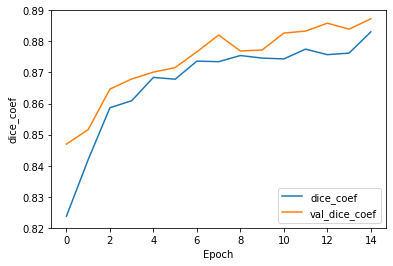

In [310]:
plt.plot(history.history['dice_coef'], label='dice_coef')
plt.plot(history.history['val_dice_coef'], label = 'val_dice_coef')
plt.xlabel('Epoch')
plt.ylabel('dice_coef')
plt.ylim([0.82, 0.89])
plt.legend(loc='lower right')

In [308]:
#Calculate DSC
all_preds = Model.predict(bmodel, test_data)

# Reshape and threshold predictions
all_preds = threshold_predictions(np.reshape(all_preds, (196, 256, 256)))

dsc_scores = []
for i in range(all_preds.shape[0]):
    dsc_scores.append(dice_coef(test_targets[i,:,:].astype('float64'), all_preds[i, :, :].astype('float64')))

print('{:.4f}±{:.4f}'.format(np.mean(dsc_scores),np.std(dsc_scores)))

0.8969±0.0735


### Compare SCT_output with test_targets to get dsc

In [288]:
#Calculate DSC
sct_dsc_scores = []
for i in range(sct_targets.shape[0]):
    sct_dsc_scores.append(dice_coef(test_targets[i,:,:].astype('float64'), sct_targets[i, :, :].astype('float64')))

print('{:.4f}±{:.4f}'.format(np.mean(sct_dsc_scores),np.std(sct_dsc_scores)))

0.8782±0.2411


In [312]:
# Save model
bmodel.save_weights('trained_15_epoch_no_augmentation.h5')